In [30]:
# Gerekli kütüphanelerin yüklenmesi
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

# Uyarıların gizlenmesi
import warnings
warnings.filterwarnings("ignore")

# Veri seti dizin yolunun eklenmesi

In [31]:
Data_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

# Sınıfların belirlenmesi

In [32]:
classes = [cls for cls in os.listdir(Data_dir) if '.' not in cls]

#  Görüntü dosyalarının yollarının ve etiketlerinin toplanması

In [33]:
labels = []
paths = []
for dir_name, _, filenames in os.walk(Data_dir):
    for filename in filenames:
        if filename.endswith('.png') and 'GT' not in dir_name.split():
            labels.append(os.path.split(dir_name)[-1])
            paths.append(os.path.join(dir_name, filename))

In [34]:
# Pandas DataFrame oluşturulması
df = pd.DataFrame({'path': paths, 'label': labels})
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB
None


# Sınıfların görselleştirilmesi

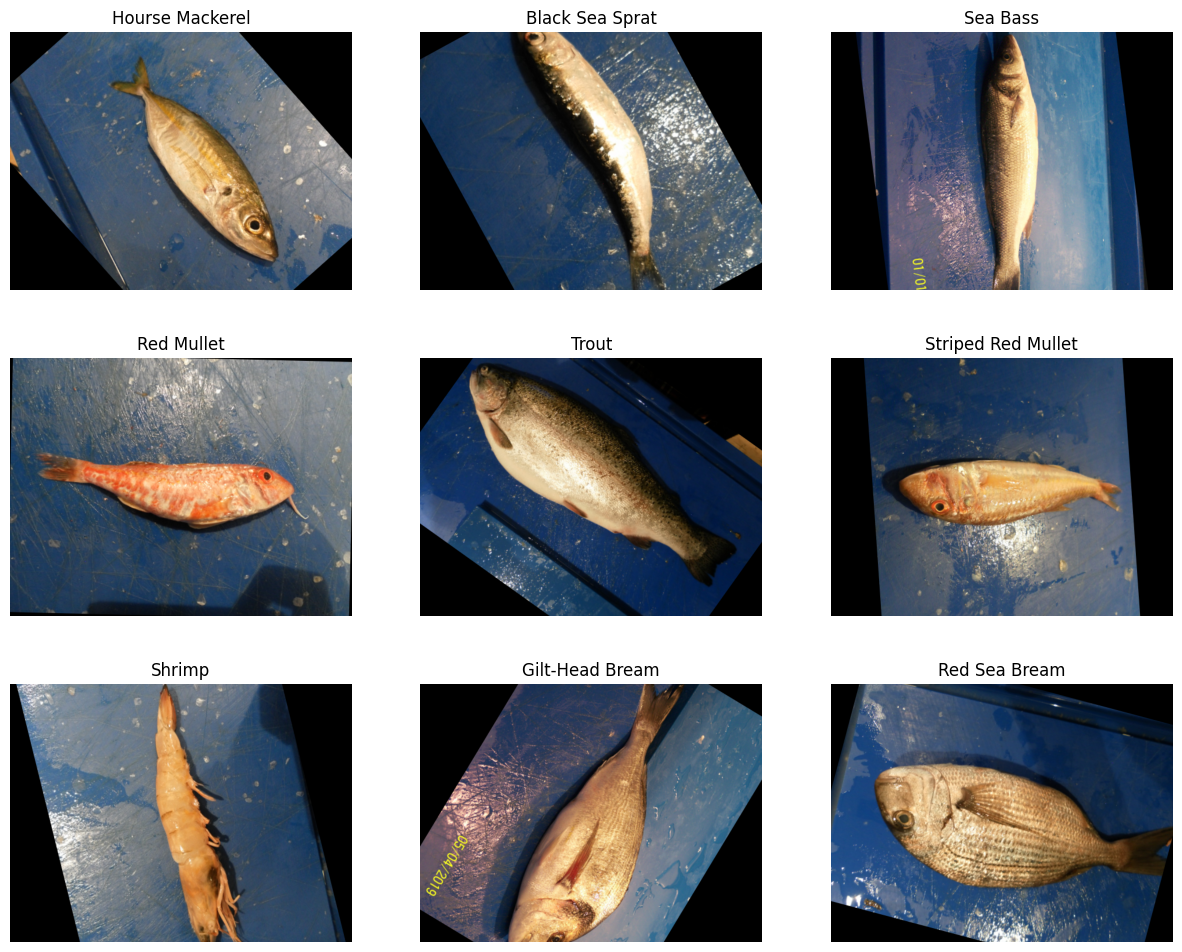

In [35]:
plt.figure(figsize=(15, 12))
for idx, label in enumerate(df['label'].unique()):
    plt.subplot(3, 3, idx + 1)
    plt.imshow(plt.imread(df[df['label'] == label].iloc[0, 0]))
    plt.title(label)
    plt.axis('off')
plt.show()

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64


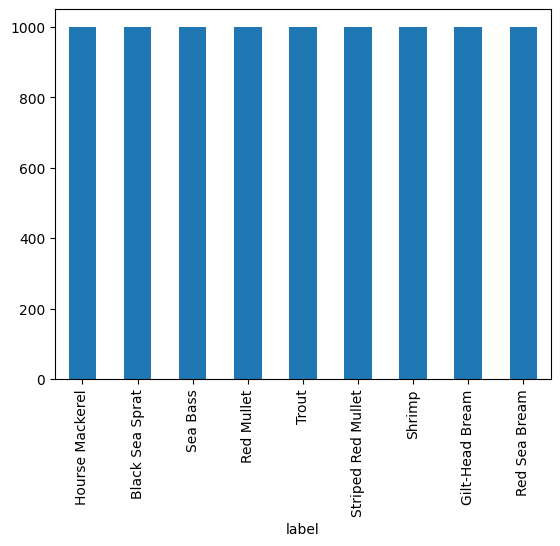

In [37]:
df['label'].value_counts().plot.bar()
print(df['label'].value_counts())

# Görüntülerin okunması ve boyutlarının ayarlanması

In [38]:
# Görüntülerin okunması ve boyutlarının ayarlanması
main_directory = Data_dir
images, labels = [], []

for directory in tqdm(os.listdir(main_directory)):
    next_directory = os.path.join(main_directory, directory)
    if directory in ["README.txt", "license.txt", "Segmentation_example_script.m"]:
        continue
    for images_directory in os.listdir(next_directory):
        if "GT" not in images_directory:
            final_directory = os.path.join(next_directory, images_directory)
            for image in os.listdir(final_directory):
                img_path = os.path.join(final_directory, image)
                with Image.open(img_path) as img:
                    img = img.resize((225, 225))  # Boyutlandırma
                    img_array = np.asarray(img).astype('float32') / 255  # Normalize etme
                    images.append(img_array)
                    labels.append(images_directory)

100%|██████████| 12/12 [01:56<00:00,  9.74s/it]


# Veri setinin eğitim, doğrulama ve test olarak bölünmesi

In [45]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Görüntü artırma işlemi

In [46]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)
datagen.fit(X_train)

# Verilerin numpy dizilerine dönüştürülmesi

In [47]:
X_train = np.array([x for x in X_train])
y_train = np.array([y for y in y_train])
X_val = np.array([x for x in X_val])
y_val = np.array([y for y in y_val])
X_test = np.array([x for x in X_test])
y_test = np.array([y for y in y_test])


# Etiketlerin One-Hot Encoding ile dönüştürülmesi

In [48]:
encoder = OneHotEncoder(sparse=False)
y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_val = encoder.transform(y_val.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

# Modelin tanımlanması

In [49]:
model = tf.keras.models.Sequential([
  # inputs 
  tf.keras.layers.Flatten(input_shape=(225, 225, 3)),
  # hiddens layers
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  # output layer
  tf.keras.layers.Dense(9,activation="softmax")
])

In [50]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 151875)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    38,880,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,914,313 (148.45 MB)

 Trainable params: 38,914,313 (148.45 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Modelin derlenmesi
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Modelin eğitimi

In [52]:
results = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)


Epoch 1/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.1922 - loss: 2.8456 - val_accuracy: 0.3611 - val_loss: 1.7981
Epoch 2/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.3301 - loss: 1.8125 - val_accuracy: 0.5522 - val_loss: 1.4470
Epoch 3/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.4372 - loss: 1.5793 - val_accuracy: 0.6089 - val_loss: 1.2878
Epoch 4/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.4673 - loss: 1.4762 - val_accuracy: 0.6311 - val_loss: 1.1552
Epoch 5/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.4987 - loss: 1.4289 - val_accuracy: 0.6500 - val_loss: 1.1076
Epoch 6/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5424 - loss: 1.2867 - val_accuracy: 0.7044 - val_loss: 0.9997
Epoch 7/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5626 - loss: 1.2416 - val_accuracy: 0.7344 - val_loss: 0.9030
Epoch 8/100
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6175 - loss: 1.1107 -

# Acc-Loss Grafiği

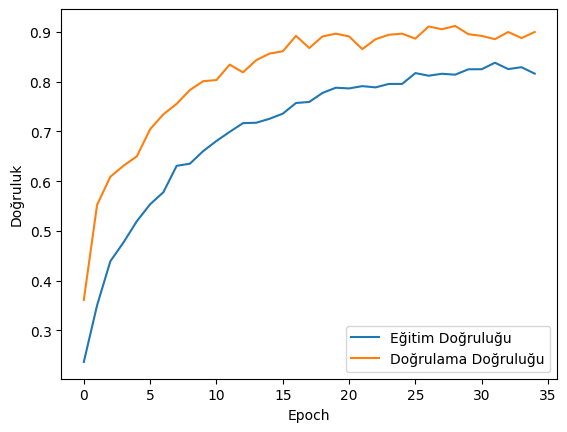

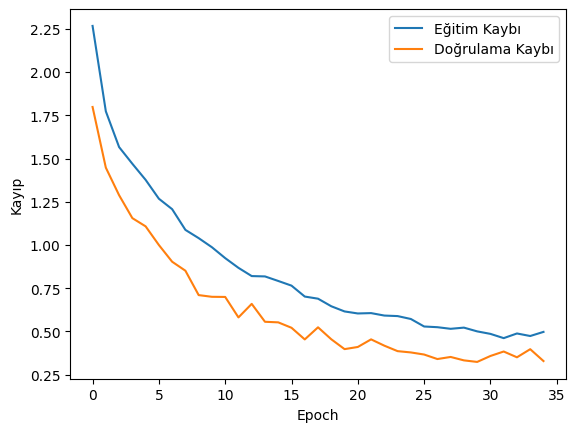

In [53]:
plt.plot(results.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(results.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

plt.plot(results.history['loss'], label='Eğitim Kaybı')
plt.plot(results.history['val_loss'], label='Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

# Test sonuçlarının değerlendirilmesi

In [54]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

29/29 - 0s - 15ms/step - accuracy: 0.8956 - loss: 0.3195
Test accuracy: 0.8955555558204651


In [55]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


              precision    recall  f1-score   support

           0       0.80      0.98      0.88        87
           1       0.94      0.82      0.88       100
           2       0.95      0.93      0.94       106
           3       0.94      0.93      0.93        85
           4       0.90      0.96      0.93        99
           5       0.81      0.91      0.85        97
           6       0.87      0.97      0.92       106
           7       0.94      0.87      0.90       116
           8       0.94      0.71      0.81       104

    accuracy                           0.90       900
   macro avg       0.90      0.90      0.89       900
weighted avg       0.90      0.90      0.89       900



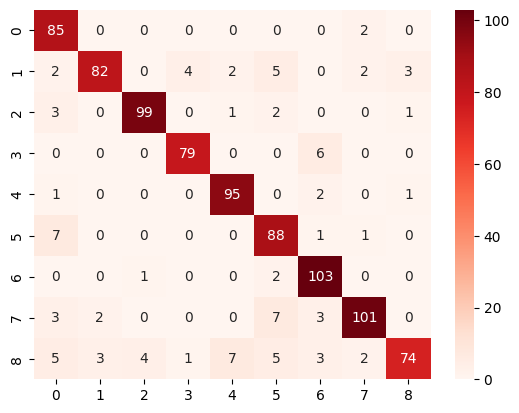

In [56]:
print(classification_report(y_true_labels, y_pred_labels))
sns.heatmap(confusion_matrix(y_true_labels, y_pred_labels), annot=True, fmt='d', cmap='Reds')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


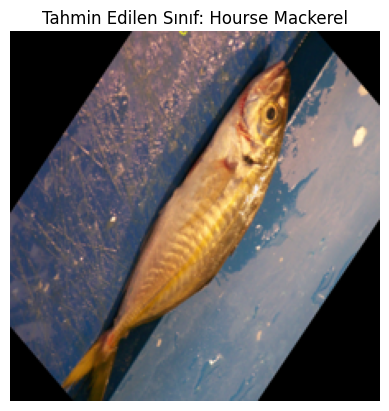

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from PIL import Image

# Örnek bir resim yükleme (Pillow ile)
image_path = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00030.png'

# Görüntüyü Pillow ile aç, boyutlandır ve normalize et
test_img = Image.open(image_path)  # Görüntüyü aç
test_img = test_img.resize((225, 225))  # Yeniden boyutlandır
test_img_array = np.array(test_img).astype('float32') / 255  # NumPy dizisine dönüştür ve normalize et

# Modelin beklediği formatta giriş oluşturmak için boyutları genişlet
test_img_array = np.expand_dims(test_img_array, axis=0)  # (1, 225, 225, 3) boyutuna genişlet

# Modelden tahmin yapma
predictions = model.predict(test_img_array)

# Tahmin edilen sınıf indeksini bulma
predicted_class_index = np.argmax(predictions)

# One-Hot formatına uygun bir dizi oluşturma
one_hot_predicted_class = np.zeros((1, encoder.categories_[0].size))
one_hot_predicted_class[0][predicted_class_index] = 1

# One-hot formatındaki sınıfı ters dönüştür
predicted_class = encoder.inverse_transform(one_hot_predicted_class)

# Tahmin sonucunu görselleştirme (Pillow ile)
plt.imshow(test_img)  # test_img PIL imaj nesnesidir, NumPy dizisi değil
plt.title(f'Tahmin Edilen Sınıf: {predicted_class[0][0]}')
plt.axis('off')  # Eksenleri gizle
plt.show()
